# Exploring machine learning with ENSO and seasonal forecasting

 * Creator(s): Chris Slocum and Yuhan "Douglas" Rao
 * Affiliation(s): NESDIS/STAR and NCICS/CISESS
 * History:
   * Created 10 August 2020



---
## Overview
In this notebook, we explore the NOAA NCEI Extended Reconstructed Sea Surface Temperature (SST) V5 dataset hosted by the NOAA Physical Systems Laboratory and Nino3.4 indices from the National Centers for Environmental Information with the Python programing language as a building block for basic machine learning vocabulary and principles. 

### Prerequisites
To successfully navigate and use this notebook, you should be accustom with:
  * Basics of Python programming (e.g., loading modules, variable assignment, plotting, familiarity with scientific Python packages)
  * Introductory statistics and linear algebra (e.g., statistical metrics, regression)

### Learning Outcomes
Through working through this notebook, you should have a basic:
  * Understanding of the lexicon for traditional machine learning
  * Familiarity with validation metrics like Pearson's correlation coefficient and root-mean-square error to evaluate a machine learning model's performance
  * Background in identifying overfitting and underfitting
---



## Tutorial

### Background
El Niño/ Southern Oscillation (ENSO) is the term used to describe the fluxuations in sea surface temperature observed in the eastern and central equatorial Pacific Ocean and the associated atmospheric pressure ocsillations.

>![Current sea surface temperature anomalies over the equatorial Pacific Ocean from the Climate Prediction Center ENSO webpage.](https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_update/sstaanim.gif)
>
> *Sea surface temperature anomalies for the last 8 weeks over the equatorial Pacific Ocean from the [Climate Prediction Center ENSO webpage](https://www.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml).*


ENSO is strongly linked with changes to the atmospheric circulation, temperature, and precipitation patterns around the globe on seasonal time scales. This behavoir is often refered to as a teleconnection. Because of this teleconnection, using ENSO observations and predictions can create an informative machine learning seasonal forecast model.

> ![ENSO equatorial Pacific Niño regions](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)
>
> *ENSO equatorial Pacific Ocean Niño regions 1+2, 3, 3.4, and 4.*

ENSO is measured over regions in the Pacific Ocean. The index particularly useful for capturing and understanding seasonal variability is the Niño3.4 region, which captures 3-month rolling average temperature anomalies. Through this index, phases of ENSO are identified
* **Neutral phase**: The Niño3.4 index is between ±0.5 °C
* **Warm phase**: The Niño3.4 index is greater than 0.5 °C. Also, referred to as El Niño.
* **Cold phase**: The Niño3.4 index is less than 0.5 °C. Also, referred to as La Niña

Changes to the sea surface temperatures occur at irregular intervals, which makes having reliable ENSO forecasts valuable. Currently, this is done with numerical weather prediction models from centers around the globe. In this tutorial, we will try to train a machine learning model to predict ENSO via the Niño3.4.

### Software
This tutorial uses the Python programming language and scientific Python packages. We will primarily use:
* netCDF4, pandas, and xarray to read in our datasets
* scikit-learn (sklean) for machine learning
* scikit-learn (sklean) and scipy for statistical metrics
* matplotlib for visualizing our data


In [ ]:
# Python packages that we will use in this notebook
%matplotlib inline
!pip install netCDF4
# Python Standard Lib
import os
import itertools
# Scientific packages
import numpy as np
import scipy.stats
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import sklearn.metrics

### Datasets
As is often the case in with geophysical datasets, we will need to handle multiple file formats.

* **Nino3.4 Index**: ASCII tab delimited file with monthly index values from 1870 to present from the NOAA Physical Sciences Labratory
* **NOAA Reconstructed SST**: NetCDF file from 1854 to present

#### Nino3.4 Index
The raw Nino3.4 Index data is structured with months as the columns and the years as the rows. For this tutorial, we want the data structured as a one-dimensional time series. The code blocks below pull the latest ASCII file from the NOAA Physical Sciences Labratory and restructures the data &mdash; understanding this step is not necessary for this tutorial, but might be of interest to you for future projects.


In [ ]:
# The commands in this cell pull the data locally
!gdown https://www.psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data

Downloading...
From: https://www.psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data
To: /content/nino34.long.anom.data
15.7kB [00:00, 13.1MB/s]       


In [ ]:
# Process and read in the data files
# ----------------------------------
# The details presented here are not relevant for the tutorial. However, this
# section does provide details for how to convert raw data formats into
# something that is AI ready

INDEX_FILE = 'nino34.long.anom.data'  # index filename
FOOTER_START = -7  # line from the end of file where the footer starts

def load_enso_indices(start_date=None, end_date=None, lead_time=0):
    """
    Reads in the txt data file to output a pandas Series of ENSO vals

    Parameters
    ---------- 
    start_date : str, optional
        the start date from which to extract sst
    end_date : str, optional
        the end date
    lead_time : int, optional
        the number of months between each sst
        value and the target Nino3.4 Index

    Returns
    -------
    enso_vals : pd.Series
        monthly ENSO values
    """
    # Read through file to extract start year, year rows index values,
    # and the missing value
    enso_vals = np.array([])
    with open(INDEX_FILE) as fid:
        lines = fid.readlines()
        # get missing value from file
        missing_value = float(lines[FOOTER_START])
        count = 1
        # get each line from the file until it reach the end of the data
        while count < len(lines) + FOOTER_START:
            vals = lines[count].split()
            if count == 1:
                start_year = vals[0]
            enso_vals = np.concatenate((enso_vals, np.float_(vals[1:])))
            count += 1
    # Convert Python list to Pandas Series for easier use
    enso_vals = pd.Series(enso_vals)
    enso_vals.replace(to_replace=missing_value, value=np.nan, inplace=True)
    # Add month information for 1D time series
    enso_vals.index = pd.date_range(f'{start_year}-01-01', freq='MS',
                                    periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    # create time slice of values set
    if start_date is not None and end_date is not None:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        if lead_time > 0:
            lead = pd.DateOffset(months=lead_time)
            start_date += lead
            end_date += lead
        enso_vals = enso_vals[slice(start_date, end_date)]
    return enso_vals


#### NOAA Reconstructed SST
The SST data is stored in the form time, latitude, and longitude. For this tutorial, we want to calculate the SST anomalies from the mean value at each grid point. The code using OpenDAP to access the data and returns that anomaly field.

In [ ]:
SST_FILE = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
def load_sst(start_date=None, end_date=None):
    """
    Loads the sea surface temperature anomaly

    Parameters
    ----------
    start_date : str, optional
        the start date from which to extract sst
    end_date : str, optional
        the end date

    Returns
    -------
    sst_amon : xr
        sea surface temperature anomaly data
    """
    # Open sst file and create xarray Dataset
    ds = xr.open_dataset(SST_FILE)
    # calculate the time axis climatology
    climatology = np.nanmean(ds['sst'], axis=0)
    # remove climatology
    anomalies = ds['sst'] - climatology
    # If date range is set, create slice
    if start_date is not None and end_date is not None:
        time_slice = slice(start_date, end_date)
        return anomalies.sel(time=time_slice)
    return anomalies

In [ ]:
# Slize to make sure that the periods are the same for both datasets
start_date = '1870-01-01'
end_date = '2019-12-31'
# Get Nino 3.4 Index values
nino34 = load_enso_indices(start_date, end_date)
# Get global SST values
sst_anom = load_sst(start_date, end_date)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


### Exploring the Niño3.4 Index and SST dataset

Before jumping into training a machine learning model, it is best to explore the data at a basic, fundemental level. This step provides information on aspects of the data that may highlight challenges and inform the type of machine learning algorithms that are applicable to the available data. From the analysis, it should be clear
* if there are any wild outlier data points that need to be addressed,
* whether gaps exist in the data, and
* what is the statistical distribution of features (predicters),  samples (how many cases you have to train the model with), and predictand.

Let's see if this is the case with our Nino3.4 values and SST data. To do this, we will plot a time series and histogram of the Nino3.4 index and contour plot of the SST values.

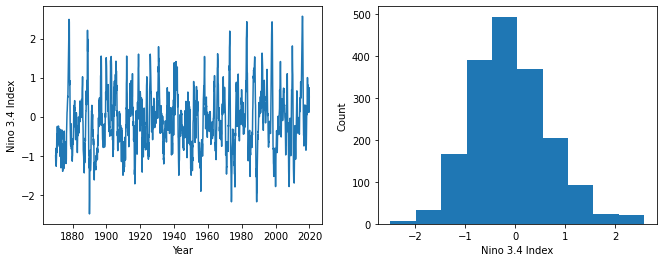

In [ ]:
# Nino3.4 Index time series
fig = plt.figure(figsize=(11,4))
ax = fig.add_subplot(1,2,1)
plt.plot(nino34)
plt.xlabel('Year')
plt.ylabel('Nino 3.4 Index')
# Nino3.4 Index histogram
ax = fig.add_subplot(1,2,2)
plt.hist(nino34)
plt.xlabel('Nino 3.4 Index')
plt.ylabel('Count');

From the plots above, a few features surface.
* The Nino3.4 Index is fairly uniformly distributed in the histogram.
* The phase clearly oscillates without a regular period from looking at the time series.
* The time series data isn't random, so it suggests that the ENSO is autoregressive, preceding index values correlate to the succeeding value.

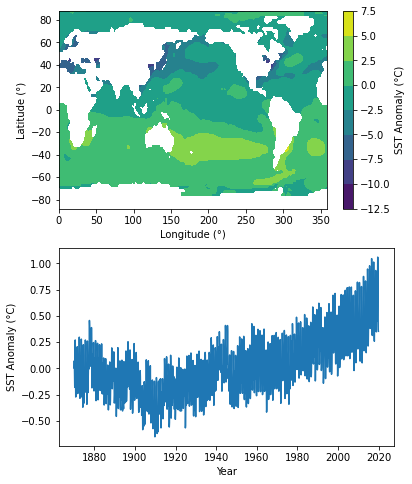

In [ ]:
# contour plot from first date
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(2,1,1)
cs = plt.contourf(sst_anom.lon, sst_anom.lat, sst_anom[0, :, :])
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
cbar = plt.colorbar(cs)
cbar.set_label('SST Anomaly (°C)')

# time series plot of mean global SST anomaly
# Note: axis=0 is time, axis=1 is latitude, and axis=2 is longitude
ax = fig.add_subplot(2,1,2)
plt.plot(sst_anom.time, sst_anom.mean(axis=(1, 2)))
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)');

In the SST anomaly contour plot, the features that standout are that:
* The data contains a land mask,
* Large spatial variability exists across the globe, and
* Regions appear to be spatially correlated
In the mean SST anomaly plot, we see
* Seasonal variability,
* A long term trend, and
* The SSTs are autoregressive.



### Identifying suitable features for machine learning

Arguably the most important (or tied for importance with interpretability) step in creating your machine learning model is to identify what information to use (features) to train the model. In creating and selecting features, domain expertise or knowledge of the dataset is invaluable. In this case, we can surmise that using the global SST dataset is too much data and individual points likely show little causal relationship to future Nino3.4 values. So, our goal is to simplify the dataset. Here are some ideas and potential pitfalls:
* Calculate the anomaly in Nino3.4 region and use that value since this is what we are predicting. *What if complex variability across the region is important or important changes begin outside the domain?*
* Coarsen the data and select points from across the Pacific. *What if this approach misses important regionality or we find a false relationship between a point and Nino3.4? Also, how well will these features hold up as the global mean continues to rise as seen in the SST time series data?*

OK, reasonable approaches and possibly good starting points. But, it might be better to try an approach to reduce the dimensionality of our problem that preserves the spatial signal. In the case of ENSO, it is well documented that the signal can be teased out of the data through using Principal Component Analysis (PCA), also called Empirical Orthogonal Functions, which is one of the more popular dimentionality reduction techniques.

Let's conduct the PCA and plot the first 7 principle component elements. Also, to help understand the data, we will print the Pearson's correlation coefficient between each principle component and the Nino3.4 Index.

---------------------------
Principle component  1
Correlation Coef   = -0.020
Variance Explained = 0.829
---------------------------
Principle component  2
Correlation Coef   = 0.201
Variance Explained = 0.032
---------------------------
Principle component  3
Correlation Coef   = 0.173
Variance Explained = 0.029
---------------------------
Principle component  4
Correlation Coef   = 0.399
Variance Explained = 0.014
---------------------------
Principle component  5
Correlation Coef   = 0.694
Variance Explained = 0.009
---------------------------
Principle component  6
Correlation Coef   = 0.176
Variance Explained = 0.006
---------------------------
Principle component  7
Correlation Coef   = -0.190
Variance Explained = 0.004


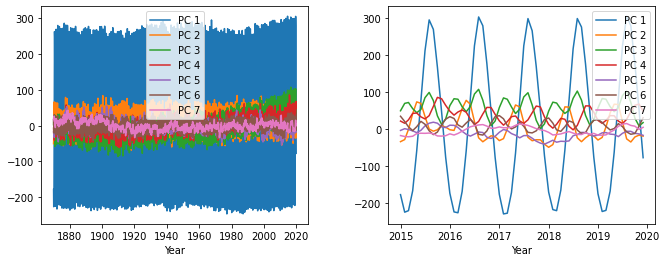

In [ ]:
# For the PCA, we need to reduce the dimensions of the data to time and space
num_time_steps = sst_anom.shape[0]
sst_flat = sst_anom.values.reshape(num_time_steps, -1)
sst_flat[np.isnan(sst_flat)] = 0
# Perform Principal Component Analysis
n_components = 12  # only take the first 12 components; saves on computational time
pca = sklearn.decomposition.PCA(n_components=n_components)
pca.fit(sst_flat)  # this is the step used to perform the PCA
X = pca.transform(sst_flat)  # this step returns the principle components

num_pcs_output = 7  # number of PCs to generate text output for
num_months = 60
fig = plt.figure(figsize=(11,4))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for i in range(num_pcs_output):
    ax1.plot(sst_anom.time, X[:, i], label='PC {:d}'.format(i+1))
    ax2.plot(sst_anom.time[-num_months:], X[-num_months:, i], label='PC {:d}'.format(i+1))
    # Calculate the Pearson R correlation coefficient
    corr, _ = scipy.stats.pearsonr(X[:, i], nino34)
    print('---------------------------')
    print('Principle component  {:d}'.format(i+1))
    print('Correlation Coef   = {:.03f}'.format(corr))
    print('Variance Explained = {:.03f}'.format(pca.explained_variance_ratio_[i]))
ax1.set_xlabel('Year')
ax1.legend()
ax2.set_xlabel('Year')
ax2.legend();

Some questions about the output from the PCA:
* What PC explains the most variance for the temperature data?
* Which PC correlates the best with the Nino3.4 Index?
* What PCs would be useful for predicting the Nino3.4 Index?


The 1st principle component element does not capture the ENSO signal. But, the 1st principle component explains 83% of the varience in our SST dataset &mdash; note that this is a relative variance explained since we only compute the first 12 principle component elements (you would need to calculate every principle component for the actual variance explained value). Looking at the last 5 years of the temperature dataset, we see that the 1st principle component is capturing the annual sea surface temperature cycle with little interannual variability.

The 5th principle component shows the strongest correlation with the ENSO signal with the 4th and 2nd showing a weak correlation.

From here, we can assume that the PCA has given us fairly useful predictors that include some of the spatial information we assume is important. By the 5th principle component, we see that it is negatively correlated to the Nino3.4 Index.

### Splitting data into training, testing, and validation sets

In machine learning, it is important to divide the data into three sets. This can be challenging.
* **Training**: The data set given to your machine learning algorithm to learn. This tends to be 60 to 80% of your data.
* **Testing**: This data is used evaluate the performance of the trained model and assess the impact of so-called hyperparameters for the particular machine learning algorithm. Typically, this is 20 to 30% of your data.
* **Validation**: This is a completely independed dataset saved until the end of development to check the final model. This data should not be used while tuning the model.

####Why not use all of the data that I have?
Metrics like Pearson's correlation coefficient and root-mean-squared error only tell you performance of the data the model has seen. If your model becomes operational, it'll likely see regimes it was not trained for. By splitting the data, you can avoid both overfitting where the model matches the training data too well and does not generalize. More details on this shortly.


In [ ]:
# Code to create splits in data
# -----------------------------
# This code uses date ranges for splitting the dataset

def create_sets(start_date, end_date, lead_time=1,
                             usepca=False, n_components=12):
    """
    Code to generate splits in our two datasets

    Parameters
    ----------
    start_date : str
        the start date from which to extract sst
    end_date : str
        the end date
    lead_time : int, optional
        the number of months between each sst
        value and the target Nino3.4 Index
    usepca : boolean, optional
        use previous instance of PCA if this step is complete
    n_components : int, optional
        the number of components for a PCA
    """
    # load for desired range
    y = load_enso_indices(start_date, end_date, lead_time=lead_time)
    sst = load_sst(start_date, end_date)
    # reduce data by a dimension
    num_time_steps = sst.shape[0]
    X = sst.values.reshape(num_time_steps, -1)
    X[np.isnan(X)] = 0
    # Perform Principal Component Analysis
    if not usepca:
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(X)
        create_sets.pca = pca
    # Apply the transform to the dataset
    X = create_sets.pca.transform(X)
    return X, y
create_sets.pca = None

####How should you split the data?
Domain expertise is likely the best thing to determine how to split the data into the three sets. In our case, randomly splitting the data could be problematic given the spatial and temporal correlated nature of the SST data. Here, we can assume that we can break the dataset into chunks of years. We pick the period from 
* 1880 to 1969 (90 years) for the training set,
* 1970 to 1999 (30 years) for the testing set, and
* 2000 to 2019 (20 years) for the validation set.

One potential issue with an approach like this is that if the dataset quality changes overtime (e.g., better SST values in the satellite era with ever improving instruments), then we might be incorperating biases into our dataset splits.

In [ ]:
lead_time = 1  # offset data by a month
# Get training data split & perform PCA on the training data
start_date_train = '1870-01-01'
end_date_train = '1969-12-31'
X_train, y_train = create_sets(start_date_train, end_date_train, lead_time=lead_time)
# Get the testing data split 
# Assign the PCA from the training data for reuse
# On our other datasets, we do not want to perform a new PCA for the testing
# data, which is against the best practices of data processing
start_date_test = '1970-01-01'
end_date_test = '1999-12-31'
X_test, y_test = create_sets(start_date_test, end_date_test, lead_time=lead_time, usepca=True)
# And, get the validation data split
start_date_val = '2000-01-01'
end_date_val = '2019-12-31'
X_val, y_val = create_sets(start_date_val, end_date_val, lead_time=lead_time, usepca=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


### Baseline linear regression model
Linear regression is simply the linear combination of $n$ number of features. We can writing this mathematically as
$$\hat{y}(w,X) = w_0 + w_1 X_1 + ... + w_nX_n,$$
where $\hat{y}$ is the predicted value, $X$ is the value of our input data or feature, and $w$ is the weight assigned to that feature ($w_0$ is the intercept and also called the bias term). Ideally, the equation above would produce a predicted value $\hat{y}$ that is equal to or sufficiently similar to our target value $y$.

A linear regression model fits the equation above by determining the set of weight coefficents, $w=(w_1, ... w_p)$, that minimize the residual of the sum of the squares
$$\min \sum_i^n ( X_i w_i - y_i )^2$$
between the targets $y_i$ and predicted values $\hat{y}_i=X_i w_i$.
The above equation is often referred to as the loss function or cost function. From linear regression to deep learning, minimizing the loss function is the goal. In this case, the function is relatively simple. However, physics could be incorperated into the function to help constrain the machine learning model.

Using the Python package scikit-learn, it is easy to train a linear regression model.

In [ ]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

####Model performance with training set

In [ ]:
# Evaluation metrics
def calc_metrics(predictions, observations):
    """
    Returns basic evaluation metrics

    Parameters
    ----------
    predictions : array-like
        the forecast/predicted values from the model
    observations: array-like
        the true values/observations

    Returns
    -------
    corr : float
    mae : float
    rmse : float
    """
    corr, _ = scipy.stats.pearsonr(predictions, observations)
    mae = sklearn.metrics.mean_absolute_error(observations, predictions)
    rmse = sklearn.metrics.mean_squared_error(observations, predictions)
    return corr, mae, rmse

Training set metrics
--------------------
r    = 0.887
MAE  = 0.258
RMSE = 0.107


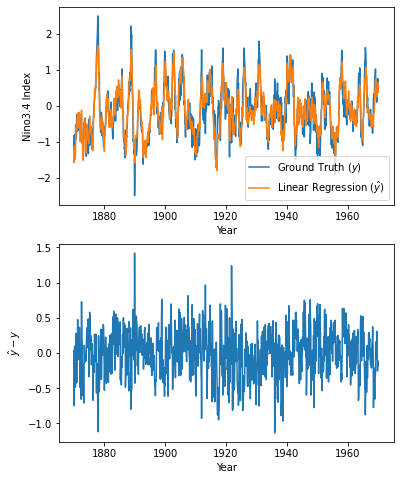

In [ ]:
# compute performance matrics with training set
predictions = regr.predict(X_train)
corr, mae, rmse = calc_metrics(predictions, y_train)
print("====================")
print("Training set metrics")
print("--------------------")
print("r    = {:.03f}".format(corr))
print("MAE  = {:.03f}".format(mae))
print("RMSE = {:.03f}".format(rmse))

# time series plot of the ground truth and the linear regression model
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2, 1, 1)
plt.plot(y_train.index, y_train, label=r'Ground Truth ($y$)')
plt.plot(y_train.index, predictions, label=r'Linear Regression ($\hat{y}$)')
plt.xlabel('Year')
plt.ylabel('Nino3.4 Index')
plt.legend()
# time series difference plot
ax = fig.add_subplot(2, 1, 2)
plt.plot(y_train.index, predictions - y_train)
plt.xlabel('Year')
plt.ylabel(r'$\hat{y}-y$');

With the current SST data being the only input information, our model does fairly well on the training data. The differences are largely confined between ±0.5 °C, which suggests that we would capture clear ENSO phases and may miss events in the transition periods between phases. Now, lets try the testing set.



####Model performance with testing set

Testing set metrics
--------------------
r    = 0.910
MAE  = 0.323
RMSE = 0.170


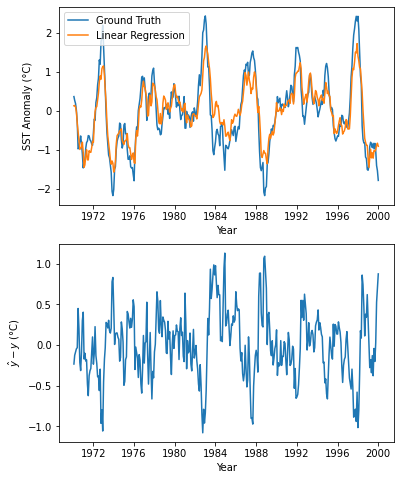

In [ ]:
# compute performance matrics with testing set
predictions = regr.predict(X_test)
corr, mae, rmse = calc_metrics(predictions, y_test)
print("====================")
print("Testing set metrics")
print("--------------------")
print("r    = {:.03f}".format(corr))
print("MAE  = {:.03f}".format(mae))
print("RMSE = {:.03f}".format(rmse))

# time series plot of the ground truth and the linear regression model
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Ground Truth')
plt.plot(y_test.index, predictions, label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
# time series difference plot
ax = fig.add_subplot(2, 1, 2)
plt.plot(y_test.index, predictions - y_test)
plt.xlabel('Year')
plt.ylabel(r'$\hat{y}-y$ (°C)');

The performance of our testing set has a slight increase in Pearson's correlation coefficient and root-mean-square error. It seems that the root-mean-square error is coming from missing the index values for extreme events. Outside of the metrics, it is clear that the model learned persistance by looking at the time series. You can see that the model misses the big changes and is delayed by several months in responding to changes in Nino3.4.

####Where to go from here?
Remember that we haven't used our validation dataset yet, so we are free to continue to explore better approaches. At this point, we will want to consider two main points:
1. Are there additional data we could use as features in our model?
2. Does our problem warrent continuing to increase the sophistication of our approach from a linear regression model?

Both points bring additional complexity to the problem and this causes it's own problems.

### Model Complexity

As mentioned at the end of the last section, model complexity can come in two forms:

1. Additional features
2. Using a sophisticated model

#### Simple toy problem
To illustrate this, we will start with a simple set of examples. In our toy problem, lets use a cosine function to represent the true signal that we'll define as
$$
y_t = \cos(x),
$$
where we specify that $0 < x < \frac{3}{2}\pi$.
And, we'll create synthetic observations or samples that include a white-noise error term
$$
y_o = \cos(x) + \varepsilon,
$$
where the error term, $\varepsilon$, is created by a random number generator for a Gaussian normal distribution with a standard deviation of $\sigma=\frac{3}{4}$ (a value that is large enough to add some spread).

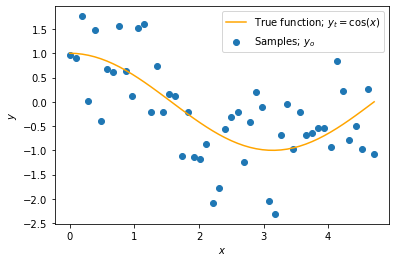

In [ ]:
x = np.linspace(0, 1.5*np.pi)
y_t = np.cos(x)  # Truth value
# The seed value produces the same random
# numbers each time the cell is run
np.random.seed(21)  
sigma = 0.75  # standard deviation or spread
epsilon = np.random.normal(scale=sigma, size=x.size)
y_o = y_t + epsilon  # synthetic observations/samples

plt.plot(x, y_t, color='orange', label='True function; $y_t=\cos(x)$')
plt.scatter(x, y_o, label='Samples; $y_o$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend();

Since machine learning is a sophisticated form of curve fitting, we'll keep this example simple by fitting a polynomial and increasing the order (deg=1, 3 ,30).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Polynomial deg=1
--------------------
       Obs    Truth
r    = 0.513, 0.766
MAE  = 0.616, 0.382
RMSE = 0.676, 0.192
Polynomial deg=3
--------------------
       Obs    Truth
r    = 0.657, 0.980
MAE  = 0.582, 0.120
RMSE = 0.522, 0.020
Polynomial deg=30
--------------------
       Obs    Truth
r    = 0.827, 0.806
MAE  = 0.441, 0.388
RMSE = 0.290, 0.222


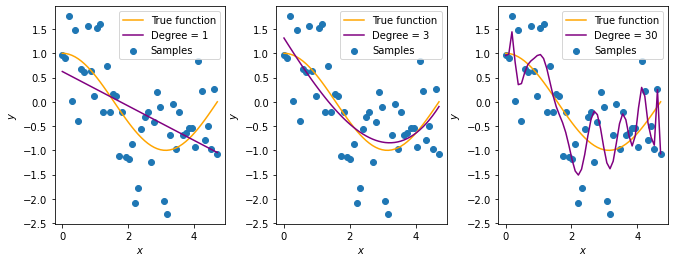

In [ ]:
degrees = [1, 3, 30]  # list of the order of the polynomial fits
# dictionary of the fit callable functions
# for each of the polynomial degree values
poly_fits = {deg: np.poly1d(np.polyfit(x, y_o, deg=deg)) for deg in degrees}

fig = plt.figure(figsize=(11,4))
fig.subplots_adjust(wspace=0.3)
for count, deg in enumerate(degrees):
    # return the y values based on x for the
    # current value of the polynomial fit
    y_poly = poly_fits[deg](x)
    # generate the metrics when compared to the obs/samples
    corr_o, mae_o, rmse_o = calc_metrics(y_poly, y_o)
    # generate the metrics when compared to the true function
    corr_t, mae_t, rmse_t = calc_metrics(y_poly, y_t)
    # output the metrics
    print("====================")
    print(f"Polynomial deg={deg:d}")
    print("--------------------")
    print("       Obs    Truth")
    print("r    = {:.03f}, {:.03f}".format(corr_o, corr_t))
    print("MAE  = {:.03f}, {:.03f}".format(mae_o, mae_t))
    print("RMSE = {:.03f}, {:.03f}".format(rmse_o, rmse_t))
    # plot a comparison
    fig.add_subplot(1, 3, count+1)
    plt.plot(x, y_t, color='orange', label='True function')
    plt.scatter(x, y_o, label='Samples')
    plt.plot(x, y_poly, color='purple', label=f'Degree = {deg:d}')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

Okay, some questions to think about regarding the output above. First focus on the error statistics [Pearson's correlation coefficient ($r$), mean absolute error (MAE), and root mean square error (RMSE)] for:

__Observations/samples column__
* What polynomial fit has the lowest errors?
* Which if any of these models could be extrapolated to values where $x<0$ or $x>\frac{3}{2}\pi$

__Truth/true function column__
* Now, considering the true function, $y_t$, which of the polynomials is better? And, what does "*better*" mean?



In general, we can think of the polynomical fit with deg=1 as being __*underfit*__. In our example, this is fairly clear. When deg=30, we might think that our fit is reasonable looking at the matrics for the observations/samples, $y_o$. In this case, we are fortunate to know the underlying function and when we compare to the truth, $y_t$, we see that we have __*overfit*__ our training dataset.

Something else to consider is that the error characteristics might change overtime (e.g., you are using output from an operational numerical weather prediction model that receives routine upgrades, an instrument begins to drift or something near the instrument changes). We'll represent these changes with the function below:
$$
y_c = \cos\left(x+\frac{\pi}{4}\right) + \varepsilon_c,
$$
and the standard deviation $\sigma_c=\frac{1}{5}$ for generating $\varepsilon_c$. Using our models derived from our old samples, we can look at how they'd preform on the new shifted data set.


Polynomial deg=1
--------------------
New    Obs    Truth
r    = 0.055, 0.000
MAE  = 0.651, 0.620
RMSE = 0.611, 0.565
Polynomial deg=3
--------------------
New    Obs    Truth
r    = 0.623, 0.611
MAE  = 0.499, 0.492
RMSE = 0.309, 0.285
Polynomial deg=30
--------------------
New    Obs    Truth
r    = 0.513, 0.531
MAE  = 0.586, 0.558
RMSE = 0.523, 0.476


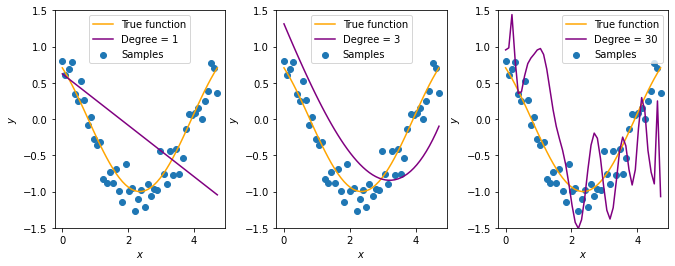

In [ ]:
np.random.seed(42)  
sigma = 0.2  # standard deviation or spread
epsilon = np.random.normal(scale=sigma, size=x.size)
y_tc = np.cos(x + np.pi/4)
y_c = y_tc + epsilon 

fig = plt.figure(figsize=(11,4))
fig.subplots_adjust(wspace=0.3)
for count, deg in enumerate(degrees):
    y_poly = poly_fits[deg](x)
    corr_tc, mae_tc, rmse_tc = calc_metrics(y_poly, y_tc)
    corr_c, mae_c, rmse_c = calc_metrics(y_poly, y_c)
    print("====================")
    print(f"Polynomial deg={deg:d}")
    print("--------------------")
    print("New    Obs    Truth")
    print("r    = {:.03f}, {:.03f}".format(corr_c, corr_tc))
    print("MAE  = {:.03f}, {:.03f}".format(mae_c, mae_tc))
    print("RMSE = {:.03f}, {:.03f}".format(rmse_c, rmse_tc))
    fig.add_subplot(1, 3, count+1)
    plt.plot(x, y_tc, color='orange', label='True function')
    plt.scatter(x, y_c, label='Samples')
    plt.plot(x, y_poly, color='purple', label=f'Degree = {deg:d}')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.ylim(-1.5, 1.5)
    plt.legend()

__Questions about the new distribution__
* How well are the models doing with the $y_{c}$ samples?
* Are any of the models able to capture/handle the $\pi/4$ shift along $x$?
* What impacts did changing $\sigma$ to a smaller value have?
* Now, what is the "*better*" model? Why and how would you quantify that?

In our toy example, we can see that our deg=3 model is biased since it does not capture the $\pi/4$ shift in the $x$. Whether this model is still reasonable depends on the application. And, likely we'd want to retrain with the new data. The other two polynomial fits could be considered bad. When deg=1, this shift can't resolve or capture the uptick in the data since this model is underfit and too simple. With deg=30, the model fit our original larger standard deviation $\sigma$ value, so the range is much larger than the new characteristics.

Again, we should note that in this toy example, we benefit from knowing true function and in Earth science problems, we often lack this information and may not know when our model is drifting and no longer captures the process we are hoping to resolve.

#### Complexity in the ENSO example

To explore complexity and the ENSO problem, we are going to select a more sophisticated machine learning algorithm. We'll note that sophisticated does not mean that we'll overfit by default. But, we want to show that our validation data set can help prevent this.

Here, we will use a [Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) designed for regression. While Support Vector Machines deserve there own tutorial as it is a powerful machine learning algorithm, the algorithm works be looking at neighboring points and waiting their relative importance. The hyper-parameter values (tunable values that change the behavior of the algorithm) essentially control the amount of influence that an value will have on predicting the final number.


As is often in the case in machine learning, users will tend to exhaust all available hyper-parameter value options to find the "*best*" performing model. This by definition can result in overfitting. Here, we select a range of hyper-parameters to test to find the best performing model. And, in Support Vector Machines for regression, the two main parameters are
* __C__: Controls [regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization) related to the [L2 norm](https://en.wikipedia.org/wiki/Norm_(mathematics)) penalty &mdash; the L2 norm is the root mean square error. Lower values result in more regularization.
* __epsilon__: The distance of influencing information.

In [ ]:
# Define parameter range 
epsilon_vals = [0.1, 0.01, 0.001]
c_vals = [1, 10, 100, 1000, 10000]

# Use itertools product to create all
# possible pairs and store to a list
params = list(itertools.product(epsilon_vals, c_vals))

# setting other model parameters mostly to
# speed up training for the example
tol = 1e-1  # lower the tolerance to reduce iterations
cache_size = 800  # increase the cache size [MB]

Ok, now to train the model. Here we are using the regression interface to the [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html) implimented into scikit-learn.

In [ ]:
# Store the "best" model parameters
min_rmse = 9999
min_params = {'C':None, 'epsilon': None, 'r': None, 'MAE': None, 'RMSE': None, 'model': None}
# It may take a few minutes to run this code block
# as Support Vector Machines are computationally intensive
# especially for large values of C

# Using an iterator to generate all possible pairs
for eps, c in params:
    print("Current pair: epsilon = {:.3f}; C = {:.0f}" .format(eps, c))
    # setup the model for the current parameters
    model = sklearn.svm.SVR(C=c, epsilon=eps, tol=tol, cache_size=cache_size)
    # fit the model to the training dataset
    model.fit(X_train, y_train)
    # get the prodictions from the training dataset
    predictions = model.predict(X_train)
    # Calculate the metrics
    corr, mae, rmse = calc_metrics(predictions, y_train)
    # Store the "best" model if current
    # pair is better
    if rmse < min_rmse:
        min_rmse = rmse
        min_params['C'] = c
        min_params['epsilon'] = eps
        min_params['r'] = corr
        min_params['MAE'] = mae
        min_params['RMSE'] = rmse
        min_params['model'] = model
# Output information about the best
# configuration found through the loop above
print("====================")
print('Best Model')
print("--------------------")
for param in min_params:
    if param != 'model':
        print("{:7s} = {:0.04f}".format(param, min_params[param]))

Current pair: epsilon = 0.100; C = 1
Current pair: epsilon = 0.100; C = 10
Current pair: epsilon = 0.100; C = 100
Current pair: epsilon = 0.100; C = 1000
Current pair: epsilon = 0.100; C = 10000
Current pair: epsilon = 0.010; C = 1
Current pair: epsilon = 0.010; C = 10
Current pair: epsilon = 0.010; C = 100
Current pair: epsilon = 0.010; C = 1000
Current pair: epsilon = 0.010; C = 10000
Current pair: epsilon = 0.001; C = 1
Current pair: epsilon = 0.001; C = 10
Current pair: epsilon = 0.001; C = 100
Current pair: epsilon = 0.001; C = 1000
Current pair: epsilon = 0.001; C = 10000
********************
Best Model
--------------------
C       = 10000.0000
epsilon = 0.0100
r       = 0.9854
MAE     = 0.0554
RMSE    = 0.0146


As we did with our multiple linear regression model, lets look at the statistics from our test data set.

Testing set metrics
--------------------
r    = 0.704
MAE  = 0.530
RMSE = 0.451


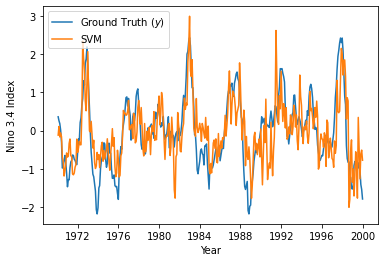

In [ ]:
# Get the predictions + metrics from the test data set
predictions = min_params['model'].predict(X_test)
corr, mae, rmse = calc_metrics(predictions, y_test)
print("====================")
print("Testing set metrics")
print("--------------------")
print("r    = {:.03f}".format(corr))
print("MAE  = {:.03f}".format(mae))
print("RMSE = {:.03f}".format(rmse))
# Plot a comparison
plt.figure()
plt.plot(y_test.index, y_test, label=r'Ground Truth ($y$)')
plt.plot(y_test.index, predictions, label=r'SVM')
plt.xlabel('Year')
plt.ylabel('Nino 3.4 Index')
plt.legend();

We can guess that we may have overfit based on the fact that the model performs nearly perfectly with the training set while performs much worse with the testing set. And, from the plot, we can see that our model is pretty noisy in comparison to the ground truth &mdash; this is from the large value of *C* selected in training. So, we need to take a different approach.

To avoid overfitting when doing a hyperparameter search, we can use the testing dataset for the verification. This approach is similiar to what is done by some grid search algorithms available from popular machine learning software packages in that a portion of data is withheld to run the statistical metrics for choosing the "*best*" model.

Current pair: epsilon = 0.100; C = 1
Current pair: epsilon = 0.100; C = 10
Current pair: epsilon = 0.100; C = 100
Current pair: epsilon = 0.100; C = 1000
Current pair: epsilon = 0.100; C = 10000
Current pair: epsilon = 0.010; C = 1
Current pair: epsilon = 0.010; C = 10
Current pair: epsilon = 0.010; C = 100
Current pair: epsilon = 0.010; C = 1000
Current pair: epsilon = 0.010; C = 10000
Current pair: epsilon = 0.001; C = 1
Current pair: epsilon = 0.001; C = 10
Current pair: epsilon = 0.001; C = 100
Current pair: epsilon = 0.001; C = 1000
Current pair: epsilon = 0.001; C = 10000
********************
Best Model
--------------------
C       = 10.0000
epsilon = 0.1000
r       = 0.9159
MAE     = 0.3125
RMSE    = 0.1606


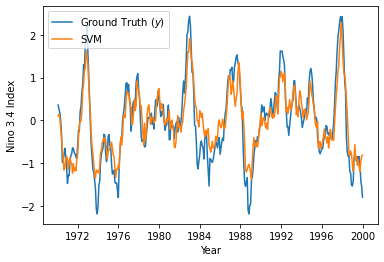

In [ ]:
# Repeat the last block, but get the metrics
# for the test rather than the training
min_rmse = 9999
for eps, c in params:
    print("Current pair: epsilon = {:.3f}; C = {:.0f}" .format(eps, c))
    model = sklearn.svm.SVR(C=c, epsilon=eps, tol=tol, cache_size=cache_size)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    corr, mae, rmse = calc_metrics(predictions, y_test)
    if rmse < min_rmse:
        min_rmse = rmse
        min_params['C'] = c
        min_params['epsilon'] = eps
        min_params['r'] = corr
        min_params['MAE'] = mae
        min_params['RMSE'] = rmse
        min_params['model'] = model
print("====================")
print('Best Model')
print("--------------------")
for param in min_params:
    if param != 'model':
        print("{:7s} = {:0.04f}".format(param, min_params[param]))
predictions = min_params['model'].predict(X_test)
# Plot a comparison
plt.figure()
plt.plot(y_test.index, y_test, label=r'Ground Truth ($y$)')
plt.plot(y_test.index, predictions, label=r'SVM')
plt.xlabel('Year')
plt.ylabel('Nino 3.4 Index')
plt.legend();

Using the test dataset to validate the model, we see that we end up with a different pair of *C* and *epsilon* values &mdash; values that should result in smoother model output at the cost of missing extreme values. And, we see that the "*best*" model has similar error metrics to our linear regression. But, this approach still has an issue in that information about the test data set is technically "*leaked*" to our model. As a result, we might still overfit. Plus, we picked a more complicated algorithm.

Fortunately, we saved a final __validation data set__, so we can perform one last test that we've saved until we are completely finished tinkering with selecting features, machine learning algorithms, and hyper-parameter values.

Validation data set
--------------------
       Linear SVM
r    = 0.921, 0.910
MAE  = 0.319, 0.310
RMSE = 0.165, 0.153


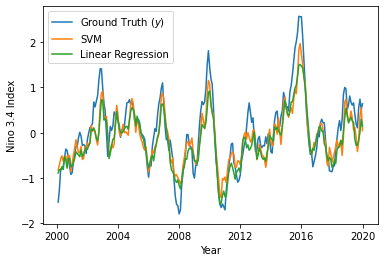

In [ ]:
# run our final regression & SVM models on the validation data
regr_predict = regr.predict(X_val)
svm_predict = min_params['model'].predict(X_val)

# calculate the metrics for both models
corr_r, mae_r, rmse_r = calc_metrics(regr_predict, y_val)
corr_s, mae_s, rmse_s = calc_metrics(svm_predict, y_val)
# Output a comparison
print("====================")
print(f"Validation data set")
print("--------------------")
print("       Linear SVM")
print("r    = {:.03f}, {:.03f}".format(corr_r, corr_s))
print("MAE  = {:.03f}, {:.03f}".format(mae_r, mae_s))
print("RMSE = {:.03f}, {:.03f}".format(rmse_r, rmse_s))

# Plot a comparison
plt.figure()
plt.plot(y_val.index, y_val, label=r'Ground Truth ($y$)')
plt.plot(y_val.index, svm_predict, label=r'SVM')
plt.plot(y_val.index, regr_predict, label=r'Linear Regression')
plt.xlabel('Year')
plt.ylabel('Nino 3.4 Index')
plt.legend();

For this specific problem, we see that our multiple linear regression and support vector machine models have similar performance. Also, more importantly, we see that the Support Vector Machine model performance did not change much from the test data set suggesting that we did not overfit in how we trained the model.


### Final thoughts
But, given that we are only using a handle of sea surface temperature anomaly principle components lagged at one month, the models are not too bad. Obviously, adding additional lagged months and more ocean information would improve the model. But, in this tutorial, we discussed
* some basic machine learning terminology,
* preprocessed data to use for a prediction task,
* discussed training, testing, and validation data sets, and
* explored the potential downfalls of increased complexity manifested as overfitting.

---
##Exercises

1. Lead time
    * Change the value of the `lead_time` variable to increase the number of offset months to a value larger than 1. How well does the basic linear model work?
    * How large can this value be and still produce a useful model?
2. Selecting better predictors/features
    * Try selecting PCs that only correlate well with the Nino3.4 Index values. Does selecting these values boost performance or generalize the mode?


## Data statement
*  [NOAA Extended Reconstructed Sea Surface Temperature (SST) V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html): historical sea surface temperatures form 1854 to present. (doi:10.7289/V5T72FNM)
*   [NOAA PSL Nino3.4 Indices](https://www.psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies in region bounded from 5°N to 5°S and 170°W to 120°W from 1870 to present. (doi:10.1029/2002JD002670)

## References

Material in this notebook is loosely adaped from the NCAR Artificial Intelligence for Earth System Science Summer School (AI4ESS; June 22 to 26) hackathon Seasonal Forecasting notebook originally developed by Ankur Mahesh under an MIT License. The source material can be access on GitHub at https://github.com/NCAR/ai4ess-hackathon-2020.

## Metadata
* Language / package(s)
   * Python
   * scikit-learn
* Domain
   * NWS
* Application keywords
   * Seasonal forecasting
* Geophysical keywords
   * ENSO
   * SST
* AI keywords
   * Support Vector Machine
   * Multivariate Linear Regression
   * Principle Component Analysis